In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import json

# Question 2: Applied Machine Learning

We first obtain the data and build the tfidf document matrix:

In [2]:
data = fetch_20newsgroups(subset='all')
tfidf_dm = TfidfVectorizer().fit_transform(data.data)

In [3]:
tfidf_dm.shape # shape=(num_docs, num_terms)

(18846, 173762)

then we split the data:

 - 10% for validation
 - 10% for testing
 - 80% for training

In [4]:
N = len(data.data)
t_N = int(0.1 * N)

indices = np.random.choice(range(len(data.data)),
                           size=2*t_N,
                           replace=False)

test_ids, valid_ids = indices[:t_N], indices[t_N:]
train_ids = np.setdiff1d(np.arange(N), indices, assume_unique=True)

assert len(train_ids) + len(test_ids) + len(valid_ids) == N

y_train = data.target[train_ids]
x_train = tfidf_dm[train_ids]
x_val = tfidf_dm[valid_ids]
y_val = data.target[valid_ids]
x_test = tfidf_dm[test_ids]
y_test = data.target[test_ids]

In [4]:
def cross_validation(nsplits, n, depth):
    kf = KFold(n_splits=nsplits, shuffle=True)
    score = 0
    
    for train_indices, test_indices in kf.split(tfidf_dm):
        rfc = RandomForestClassifier(n_estimators=n, max_depth=depth)
        rfc.fit(tfidf_dm[train_indices], data.target[train_indices])
        score += rfc.score(tfidf_dm[test_indices], data.target[test_indices])

    score /= kf.get_n_splits()
    return score

In [ ]:
# grid search n_estimators and max_depth SLOW
accuracies = []
for n in range(25, 35):
    # run once with no max to get upper bound
    for depth in range(75, 95):
        score = cross_validation(5, n, depth)
        accuracies.append((n, depth, score))
        print('n=', n, 'd=', depth, score)        
    print('Done with n=', n)

n= 25 d= 75 0.762549149737
n= 25 d= 76 0.768226457214
n= 25 d= 77 0.77225925866
n= 25 d= 78 0.765043165908
n= 25 d= 79 0.773373682977
n= 25 d= 80 0.769234259944
n= 25 d= 81 0.76605117977
n= 25 d= 82 0.77103915581
n= 25 d= 83 0.766369073969
n= 25 d= 84 0.769288126719
n= 25 d= 85 0.775071577218
n= 25 d= 86 0.773002555399
n= 25 d= 87 0.768598358942
n= 25 d= 88 0.77188776512
n= 25 d= 89 0.766793843114
n= 25 d= 90 0.770455390302
n= 25 d= 91 0.770827109049
n= 25 d= 92 0.773691478648
n= 25 d= 93 0.770720529688
n= 25 d= 94 0.777405738423
Done with n= 25
n= 26 d= 75 0.77045440502
n= 26 d= 76 0.770189181181
n= 26 d= 77 0.777672017921
n= 26 d= 78 0.767377453792
n= 26 d= 79 0.776397654184
n= 26 d= 80 0.771782283644
n= 26 d= 81 0.769394494948
n= 26 d= 82 0.773958039655
n= 26 d= 83 0.77358625053
n= 26 d= 84 0.776504135017
n= 26 d= 85 0.774116205566
n= 26 d= 86 0.770455094717
n= 26 d= 87 0.776398681693
n= 26 d= 88 0.779316706934
n= 26 d= 89 0.77597427851
n= 26 d= 90 0.777459858556
n= 26 d= 91 0.77756

In [ ]:
#with open('tmp.json', 'w') as f:
#    json.dump(accuracies, f)

In [6]:
#with open('tmp.json', 'r') as f:
#    accs = json.load(f)

In [7]:
a = sorted(accs, key=lambda t: t[2])

In [11]:
a[-1]

[27, 81, 0.7913351016799293]

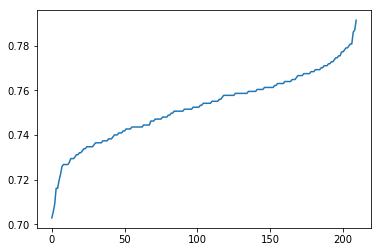

In [10]:
plt.plot([a[2] for a in a])